# Extract text and images from pdf

<b>Imports</b> 

To use pytesseract (on Windows): <br>
conda install -c conda-forge pytesseract <br>
conda install -c conda-forge tesseract <br>

 <br>

To use pdf2image: <br>
conda install -c conda-forge pdf2image <br>
conda install -c conda-forge poppler <br>

In [1]:
#new
import pytesseract
from pdf2image import convert_from_path

#should already have
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re

import os

Here, the path to tesseract and tessdata need to be specified for the program to work.

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\annut\miniconda3\envs\Tehisintellekt\Library\bin\tesseract.exe'
os.environ['TESSDATA_PREFIX'] = r'C:\Users\annut\miniconda3\envs\Tehisintellekt\share\tessdata/'

Some parameters need to pe specified in order to use the program and improve its quality.

<b>path</b> - this is where the found images will be saved <br>
<b>filename</b> - location + name of the pdf file<br>
<b>language</b> - the language in which the pdf is in (est for Estonian, eng for English and so on: https://www.labnol.org/code/19899-google-translate-languages)<br>
<b>page_numbers</b> - whether the pdf pages have page numbers at the end (True) or not (False)<br>
<b>skip_images_without_text</b> - whether the program should skip images that are on pages without any text (True) or not (False)<br>
<b>skip_slides</b> - slide numbers to skip (example: "1-3, 5", slides 1, 2, 3 and 5 will be skipped)

In [3]:
path = "images/"
filename = 'Universum.pdf'
language = 'est'
page_numbers = True
skip_images_without_text = True
skip_slides = ""

In [4]:
#source: https://stackoverflow.com/questions/57249273/how-to-detect-paragraphs-in-a-text-document-image-for-a-non-consistent-text-stru
def getParagraphs(image):
    paragraphs = []
    image_np = np.array(image)
    
    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(thresh, kernel, iterations=12)

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        rect = [x, y, w, h]
        paragraphs.append(rect)
    
    return paragraphs


def getContent(filename, lang, skipped):
    text = ""
    pictures = []
    picture_count = 0
    
    images = convert_from_path(filename)
    pattern = r"[a-zöüõäA-ZÖÄÜÕ][a-zöüõäA-ZÖÄÜÕ]+[,\/-:;?!]*"
    
    for j in range(len(images)):
        if j+1 not in skipped:
            image = images[j]
            paragraphs = getParagraphs(image)

            for i in range(len(paragraphs)-1, -1, -1):

                if i == 0 and page_numbers:
                        break

                p = paragraphs[i]
                x, y, w, h = p[0], p[1], p[2], p[3]
                segment = image.crop((x, y, x + w, y + h))

                unique_colors = set(segment.getdata())

                if len(unique_colors) > 15000:
                    if len(paragraphs) == 1 and skip_images_without_text:
                        break
                    else:
                        picturefilename = "Picture_" + str(picture_count) + ".png"
                        cv2.imwrite(path + picturefilename, np.array(segment))
                        text += "(Vaata: Pilt " + str(picture_count) + ") "
                        picture_count +=1
                        pictures.append(picturefilename)

                else: 
                    extracted_text = pytesseract.image_to_string(segment, lang=lang)
                    sentence = extracted_text.strip().replace('\n', " ")
                    raw_text = re.findall(pattern, sentence)

                    if len(raw_text) > 0:
                        text += ' '.join(raw_text).replace(";", "").replace(":", "").capitalize() + ". "                        
    return text, pictures

def getSkippedSlides(skip):
    skipped = []
    if skip == "":
        return skipped
    slides = skip.replace(" ", "").split(",")
    
    for slide in slides:
        if "-" in slide:
            no = slide.split("-")
            for i in range(int(no[0]), int(no[1])+1):
                skipped.append(i)
        else:
            skipped.append(int(slide))
    return skipped
    

In [5]:
skipped = getSkippedSlides(skip_slides)
text, pictures = getContent(filename, language, skipped)
print(text)

Päikesesüsteem. (Vaata: Pilt 0) Vanad kreeklased teadsid lisaks päikesele, kuule ja kinnistähtedele viit planeeti aävnteg dotepeg rändavad tähed või lihtsalt rmhavfrai hulkurid merkuur, veenus, marss, jupiter, saturn, samuti komeete koufitng pikajuukselised tähed ja meteoore uer wpa taevanähtus, kõrgel õhus. Kõige keskpunktiks oli maa. Mikotaj kopernik kõik tiirlemised toimuvad ümber päikese. Galileo galilei esimesed teleskoobivaatlused ka jupiteri ümber tiirlevad kuud veenusel esinevad faasid nagu kuul kuu ja päikese pind ei ole ideaalne. Arusaamine, et on olemas mingi päikese ümber koonduvate taevakehade süsteem, hakkas kujunema sajandil. Aastal oli marss maale erakordselt lähedal ca miljonit km ehk au. Itaalia astronoom giovanni schiaparelli arvas marsil nägevat vagusid, nõgusid või jõesänge, mida ta nimetas canali. Inglise keelde tõlgiti see kui canals õigem oleks olnud channels või grooves insismgat. Tnd ne. Usa ärimees percival lowell rajas arizona osariigis flagstaffis oma eraob

In [8]:
def getParagraphs(image, iterations):
    '''This function return the locations of paragraphs on a slide found by using dilation.'''
    paragraphs = []
    image_np = np.array(image)
    
    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(thresh, kernel, iterations=iterations)

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        rect = [x, y, w, h]
        paragraphs.append(rect)
    
    return paragraphs

1
2
3


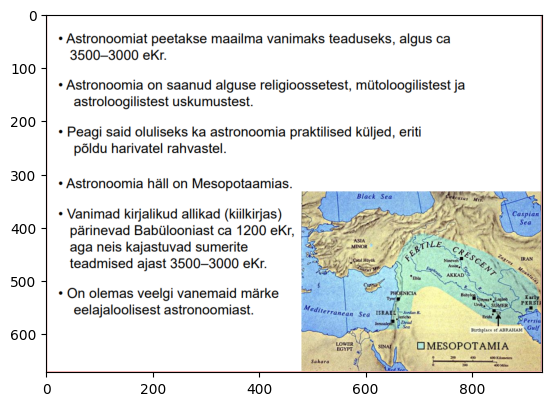

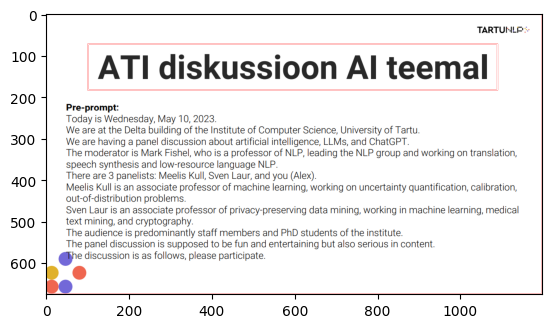

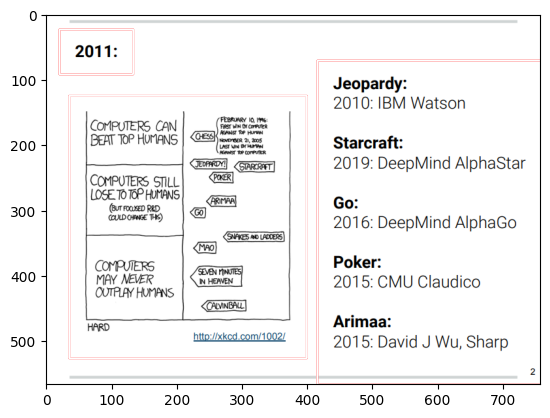

In [19]:
p1 = Image.open("p1.png")
p2 = Image.open("p2.png")
p3 = Image.open("p3.png")

r1 = getParagraphs(p1, 12)
r2 = getParagraphs(p2, 12)
r3 = getParagraphs(p3, 12)

print(len(r1))
for p in r1:
    x,y,w,h = p[0], p[1], p[2], p[3]
    segment = p1.crop((x, y, x + w, y + h))
    p1.save("test.png")
    p1 = np.array(p1)
    cv2.rectangle(p1, (x, y), (x + w, y + h), (255,0,0), 2)

print(len(r2))
for p in r2:
    p2 = np.array(p2)
    x,y,w,h = p[0], p[1], p[2], p[3]
    cv2.rectangle(p2, (x, y), (x + w, y + h), (255,0,0), 2)

print(len(r3))
for p in r3:
    x,y,w,h = p[0], p[1], p[2], p[3]
    p3 = np.array(p3)
    cv2.rectangle(p3, (x, y), (x + w, y + h), (255,0,0), 2)
    
plt.imshow(p1)
plt.show()
plt.imshow(p2)
plt.show()
plt.imshow(p3)
plt.show()